In [43]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
import numpy as np
import sympy as sy
from sympy import symbols
from scipy import interpolate
from scipy import optimize
import matplotlib
from matplotlib import pyplot as plt

In [44]:
##PARAMETRI INIZIALI

pars = camb.CAMBparams()  #0.022 0.122 67.5
pars.set_cosmology(H0=73, ombh2=0.023, omch2=0.111)   #H0= hubble parameter today in km/s    ombh2=physical density in baryons omch2=physical density in cold dark matter
#trovo densità diverse...
pars.InitPower.set_params(ns=0.965)  #ns = scalar spectra index (inflaction)


class: <InitialPowerLaw>
 tensor_parameterization = tensor_param_rpivot
 ns = 0.965
 nrun = 0.0
 nrunrun = 0.0
 nt = -0.0
 ntrun = -0.0
 r = 0.0
 pivot_scalar = 0.05
 pivot_tensor = 0.05
 As = 2e-09
 At = 1.0
 

In [45]:
pars.set_matter_power(redshifts=[2], kmax=3.0)  
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)   

In [46]:
def dist(z):   #funzione per trasformare il redshift in distanza
    return results.comoving_radial_distance(z) #coefficiente per trasformare il redshift in un raggio, c/H0 = [km/s  / (km/s)/Mpc] = [Mpc], z è adimensionale


In [47]:
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-2, maxkh=1e-1, npoints = 100) #nota, le z vengono ordinate, ricavo spettro di potenza

In [48]:
H0 = results.hubble_parameter(0)    #parametri di hubble
h = H0/100
def H(z):
    return results.hubble_parameter(z)

kh = kh/h  #H0 = 70km/(s*Mpc) h=0.7 ma non era senza unità di misura?
pk = pk*h**3

In [49]:
bias = 1 + z[0]*0.84   #funzione di bias delle galassie, cercane altre!!
f = (results.get_fsigma8()/results.get_sigma8())
 #la calcola alla z scelta già, UNITà DI MISURA

mu = np.arange(-1,1,0.1)      #range di valori dell'angolo
N = len(kh)*len(mu)   #numero di dati simulati

In [50]:
#Set di dati simulati spettro di potenza delle galassie

Pgg = np.empty((len(kh),len(mu)))
for i in range (len(kh)):
    for j in range (len(mu)):
        Pgg[i][j] = ( float(np.power(bias + f * np.power(mu[j],2),2)*pk[:,i]))


In [51]:
#Dati per la funzione teorica
#om=(0.134)/(h**2)  #PRESO DA QUELLE INIZIALI MA NON TORNANO COI DATI, ho usato una h diversa
#omb= 0.31  # densità di materia per z=0, presa da libro
om = results.get_Omega('cdm',0) + results.get_Omega('baryon',0)    #densità di materia nell'universo
omz= om*(1+z[0])**3/(H(z[0])/H0)**2 #densità di materia a diverso z
omz

0.8963052488262638

In [52]:
print(f)
print(omz**0.545)

[0.94612751]
0.9420815252777087


In [53]:
##Errori dei dati simulati
ng= 15e-4   #mean galaxy number density for z near 0 (Euclid spettroscopy survey)
DeltaMu = np.abs(mu[0]-mu[1])
DeltaZ = 0.1
DeltaK = np.empty((len(kh)))

for i in range (len (kh)):
    if i==0 : DeltaK[i]= np.abs(kh[i+1]-kh[i])
    elif i==len(kh)-1:
       DeltaK[i]= np.abs(kh[i-1]-kh[i])
    else: DeltaK[i]= np.abs(kh[i+1]-kh[i])/2+ np.abs(kh[i-1]-kh[i])/2
    if(DeltaK[i]<1e-2): DeltaK[i]=1e-2   #l'intervallo deve comunque essere più grande di kmin, se non lo è lo metto uguale a kmin
    
N = np.empty((len(kh),len(mu)))
Vol = 4./3.*np.pi*((dist(z[0]+DeltaZ/2))**3-(dist(z[0]-DeltaZ/2)**3))    #calcolo il volume di cielo considerato, inmmagino di guardare il cielo su tutti gli angoli (ideale)

for j in range(len(kh)):
    N[j,:]= Vol*1/(2*np.pi)**2 * kh[j]**2*DeltaMu*DeltaK[j]  #uguale per tutte le mu

err_Pgg = np.empty((len(kh),len(mu)))
for i in range (len(kh)):
    for j in range (len(mu)):
        err_Pgg[i][j] = np.sqrt(2/N[i][j])*(Pgg[i][j]+1/ng)




In [54]:
#cerco la distanza minima, per risalire il kmin da mettere all'inizio del codice

kmin= 2*np.pi/(dist(z[0]+DeltaZ/2)-dist(z[0]-DeltaZ/2))
kmin*h

0.03073494408317064

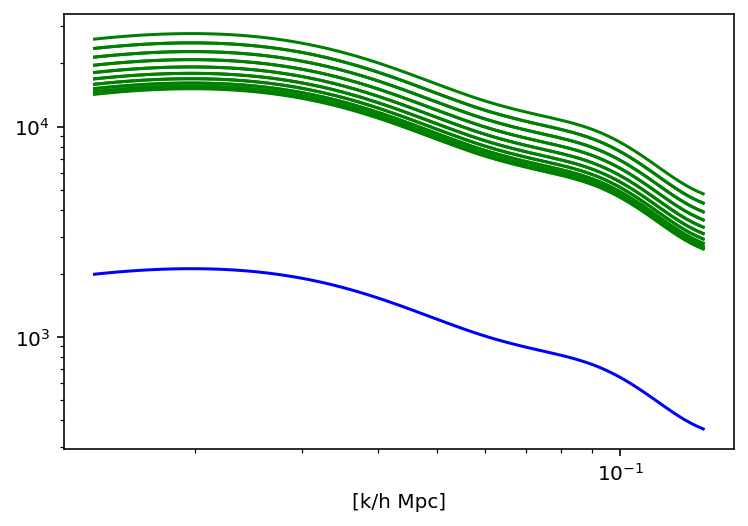

In [55]:
#Grafico

fit, ax = plt.subplots()

ax.set_xlabel('[k/h Mpc]')
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(kh, pk[0,:], color='b', ls = '-')
for i in range(len(mu)):
    ax.plot(kh, Pgg[:,i], color='g', ls ='-')  #aggiungi gli errori

#ax.legend(['matter','galaxy'], loc='lower left')
#plt.title('Total Matter power at z=%s and z= %s'%tuple(z));

[2447.91532177 2407.97568111 2367.82220564 2327.46564299 2286.91780818
 2246.18941003 2205.29045378 2164.23229731 2123.0276834  2081.68983044
 2040.23181436 1998.66802739 1957.0142973  1915.28727305 1873.50295497
 1831.67838631 1789.83208629 1747.98383026 1706.15354629 1664.36198249
 1622.63124181 1580.98467707 1539.44641094 1498.04130629 1456.79526955
 1415.73516188 1374.88913691 1334.2868527  1293.95849901 1253.93457284
 1214.24645893 1174.9282189  1136.01404657 1097.53741366 1059.53152653
 1022.03339782  985.08064314  948.70864737  912.95073324  877.84336812
  843.42520463  809.73101474  776.79153837  744.63843058  713.30820092
  682.83233825  653.23632697  624.54241587  596.77705709  569.96211409
  544.11241238  519.23764195  495.35329913  472.47353914  450.60455619
  429.74529555  409.88428074  391.00107019  373.07209264  356.07150301
  339.97994483  324.79257468  310.5013421   297.09342417  284.53757382
  272.76139916  261.69230146  251.26494325  241.41999328  232.10332901
  223.

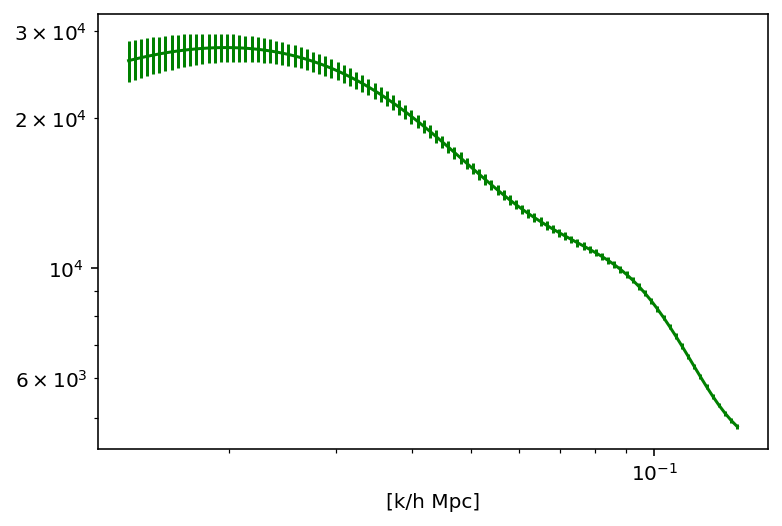

In [56]:
fit, ax = plt.subplots()

ax.set_xlabel('[k/h Mpc]')
ax.set_xscale('log')
ax.set_yscale('log')

ax.errorbar(kh, Pgg[:,0], yerr = err_Pgg[:,0], color='g', ls ='-')  #aggiungi gli errori
print(err_Pgg[:,0])


In [66]:
gammas= np.arange(0.48,0.53,0.001)   #calcolo il chi quadro per un certo set di valori di gamma

for k in range(len(gammas)):
    gammas[k] = round (gammas[k],3)

chi2 = np.zeros(len(gammas))


for k,gamma in enumerate(gammas):
    for i in range (len(kh)):
        for j in range (len(mu)):
            chi2[k]= chi2[k]+(float((bias + (omz**gamma) * (mu[j])**2)**2*pk[:,i]) - Pgg[i][j])**2/err_Pgg[i][j]**2
        



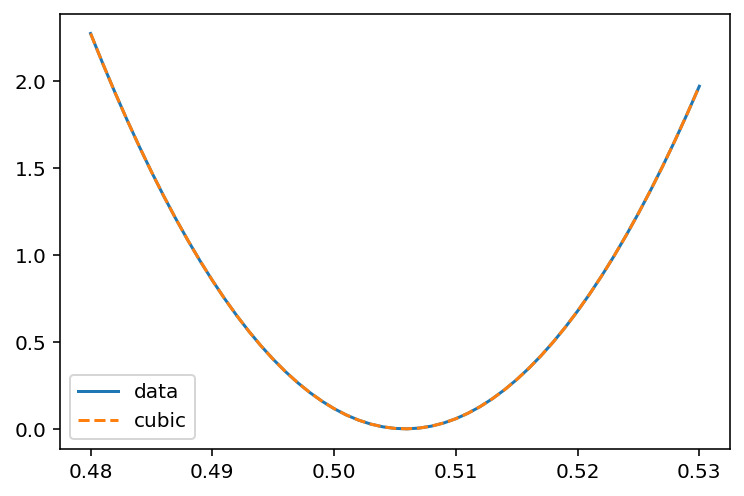

In [67]:
#INTERPOLAZIONE FUNZIONE CHI^2
interpol =  interpolate.interp1d(gammas,chi2,kind='cubic')
plt.plot(gammas,chi2,'-', gammas, interpol(gammas), '--')
plt.legend(['data', 'cubic'])


#plt.axis([0.54,0.56,0,0.4e9])

In [68]:
type(interpol)
y=lambda x: interpol(x)


In [69]:

minimo = optimize.least_squares(y,0.5)
min1= float(minimo.x)
minimo

 active_mask: array([0.])
        cost: 6.11103202808987e-15
         fun: array([1.10553444e-07])
        grad: array([-4.27295047e-09])
         jac: array([[-0.03865054]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 11
        njev: 11
  optimality: 4.272950469347304e-09
      status: 1
     success: True
           x: array([0.50584778])

In [70]:
chi2min= y(min1)

In [71]:
min2= np.min(chi2)      #trova un valore minimo di chi2, solo a livello discreto, meno preciso
index_min = np.argmin(chi2)
gamma_min = gammas[index_min]
gamma_min

0.506

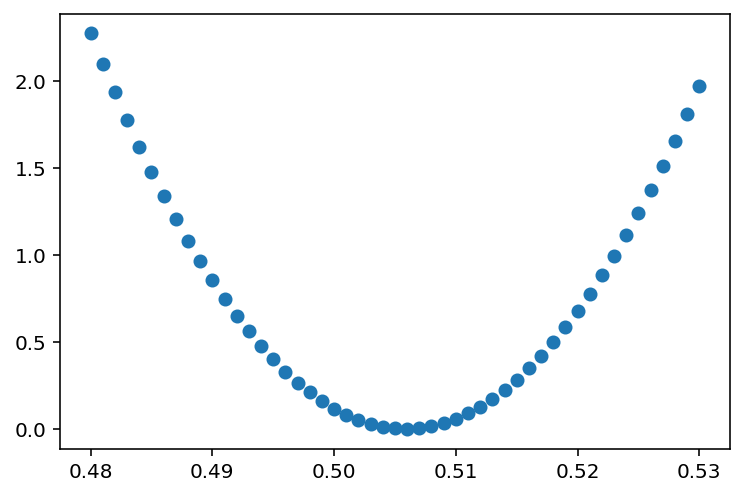

In [72]:
plt.scatter(gammas,chi2)

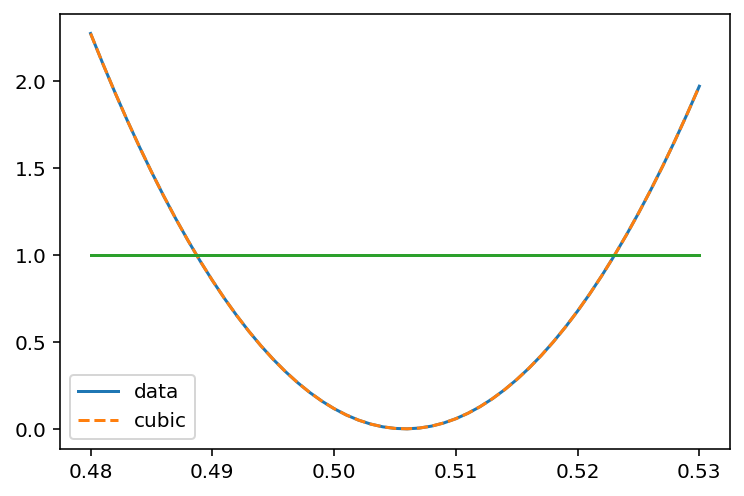

In [73]:
#devo scalare il grafico
plt.plot(gammas,chi2-chi2min,'-', gammas, interpol(gammas)-chi2min, '--')
plt.legend(['data', 'cubic'])

#CALCOLO DELL'ERRORE
xpoints= np.arange(0.48,0.53,0.001)
ypoints = np.ones(len(xpoints))
plt.plot(xpoints,ypoints)



In [74]:
y2= lambda x: interpol(x) - 1 -chi2min
error1 = optimize.brentq(y2,0.48,0.5)    #trova le soluzioni in un intervallo fissato
error2 = optimize.brentq(y2,0.5,0.53)
print(error1,error2)

0.4886899254868232 0.5230556863485354


In [75]:
print(np.abs(min1-error1))
print(np.abs(min1-error2))

sigma = 0.006

0.01715785248683499
0.01720790837487718


In [ ]:
print("Il valore di gamma trovato è: ", round(min1,3) ," +- ", sigma)

Il valore di gamma trovato è:  0.549  +-  0.006


In [ ]:
#facciamo il fit, posso usare optimize perché ho l'errore su una sola variabile

#def func(i, gamma):
#    return (bias + (omz**gamma) * (mu[j])**2)**2*pk[:,i]
#
#index = np.array(0,len(kh),1)
#popt, pcov = optimize.curve_fit(func, index , Pgg[:,?], err_Pgg)  #non so che fare con ste mu
